In [1]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [2]:
dpe = DPE('COM3')

Running <function DPE.init_dut at 0x0000020EC19940D8> with serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.03s
Serial disconnected


In [3]:
dpe.set_clock(50)

Running <function DPE.set_clock at 0x0000020EC19941F8> with serial
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [4]:
g = dpe.read(0)

Running <function DPE.read at 0x0000020EC1994318> with serial
[INFO] Elapsed time = 0.25s
Serial disconnected


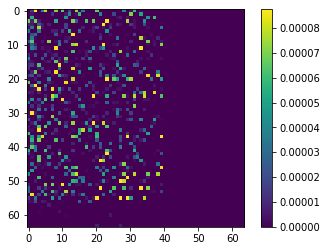

In [5]:
plt.imshow(g)
# plt.clim(0, 2e-4)
plt.colorbar()

In [6]:
nn = NN_dpe(weights)

In [7]:
img_idx = 6

image = test_images[img_idx]
vectors = nn._conv_flattern(image)
vectors.max()

1.0

In [8]:
outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2

Running <function DPE.multiply at 0x000001D6D15534C8> with serial
[INFO] Elapsed time = 1.54s
Serial disconnected


In [17]:
outputs.shape

(400, 14)

In [20]:
software = (finalGconv.T @ vectors).T / (nn.Gratio/2)

In [ ]:
for c in range(14):
    x = []
    y = []
        
    plt.figure(c+1)
    plt.title(f'Column {c}')
    plt.plot(outputs[:,c],software[:,c], '.', alpha=0.3)
    plt.xlabel('Expectation')

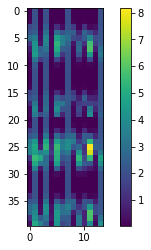

In [22]:
plt.imshow(software[:40])
plt.colorbar()

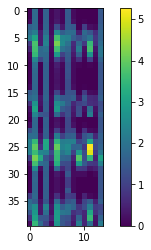

In [23]:
plt.imshow(outputs[:40])
plt.colorbar()

In [28]:
linear_factors_conv = []
for c in range(14):
    linear_factors_conv.append( np.polyfit(outputs[:,c], software[:,c], 1))
    
linear_factors_conv = np.array(linear_factors_conv)
linear_factors_conv

array([[ 1.10600809,  0.02558262],
       [ 1.0400355 ,  0.85863644],
       [ 1.30230276,  0.00215507],
       [ 1.44122246, -0.16235268],
       [ 1.23063979, -0.09618758],
       [ 1.08255167,  0.03345652],
       [ 1.10381478, -0.07628634],
       [ 1.23586714,  0.08344223],
       [ 1.06021022, -0.08062452],
       [ 1.37758174, -0.16723768],
       [ 1.17893294,  0.0187636 ],
       [ 1.12354446,  0.03942665],
       [ 1.22563643,  0.01260009],
       [ 0.79969926,  0.41632605]])

In [9]:
for c in range(outputs.shape[1]):
    outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]

In [31]:
result = outputs[:, ::2] - outputs[:,1::2]
x = result.reshape(20,20,-1)
# for i in range(7):
#     plt.figure(i)
#     plt.imshow(x[:,:,i])
#     plt.colorbar()

In [32]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print('predicted', y.argmax())
print('label', test_labels[img_idx])

predicted 4
label 4


In [ ]:
xs = []
acc = []

for img_idx in range(len(test_images)):
    
    
    image = test_images[img_idx]
    vectors = nn._conv_flattern(image)
    
    outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2
    
    for c in range(outputs.shape[1]):
        outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]
    
    result = outputs[:, ::2] - outputs[:,1::2]
    x = result.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    xs.append(x1)
    y = nn.dense(x1)
    
    display.clear_output(wait=True)

    print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
    acc.append( y.argmax() == test_labels[img_idx] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
    
save_workspace(vars(), note='mnist_xs')

In [8]:
load_workspace(vars(), 'dataset/20190821-051552-mnist_xs')

# load_workspace(vars(), 'mnist_xs_software')
xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 


In [9]:
# Check xs 
acc = []

for img_idx in range(len(test_images)):
    x1 = xs[img_idx]
    y = nn.dense(x1)
    
    if (img_idx+1)%100 == 0:
        display.clear_output(wait=True)

        print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
        acc.append( y.argmax() == test_labels[img_idx] )
        print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')

idx=9999, predicted: 6, label: 6
	 Accuracy = 98.00%


In [10]:
xs

array([[ 1.43760178, -0.        ,  2.6677077 , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.40300978,  0.68757231,  2.79176243, ..., -0.        ,
         3.54113916,  2.61077068],
       [-0.        , -0.        ,  0.06726302, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        ,  0.11108644, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.11126897, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.79958419, ..., -0.        ,
         3.2943451 ,  1.30286908]])

In [11]:
xs = np.array(xs)
xs.shape

(10000, 112)

In [12]:
xs = np.concatenate((xs, np.ones((xs.shape[0], 1))), axis=1)

In [13]:
xs.shape

(10000, 113)

Running <function DPE.read at 0x0000020EC1994318> with serial
[INFO] Elapsed time = 0.25s
Serial disconnected


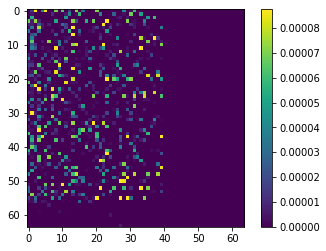

In [14]:
plt.imshow(dpe.read(0))
plt.colorbar()

In [15]:
import scipy.io as sio
mat_contents = sio.loadmat('UpdatedGfc.mat')
finalGfc = mat_contents['finalGfc']

In [16]:
x = xs[0:400]

x1 = x[:,:57].T
x2 = x[:,57:].T

sc1 = x1.max()
sc2 = x2.max()

Gfc1 = finalGfc[:57]
Gfc2 = finalGfc[57:]

x1 = x1 / sc1
x2 = x2 / sc2

In [17]:
output1 = dpe.multiply_w_delay(0, x1, c_sel=[0, 20], delay=0, debug=True)
software1 = (Gfc1.T @ x1).T 

output2 = dpe.multiply_w_delay(0, x2, c_sel=[20, 40], delay=0, debug=True)
software2 = (Gfc2.T @ x2).T 

Running <function DPE.multiply_w_delay at 0x0000020EC19948B8> with serial
[DEBUG] processing vector 0
[DEBUG] processing vector 50
[DEBUG] processing vector 100
[DEBUG] processing vector 150
[DEBUG] processing vector 200
[DEBUG] processing vector 250
[DEBUG] processing vector 300
[DEBUG] processing vector 350
[DEBUG] processing vector 0
[DEBUG] processing vector 50
[DEBUG] processing vector 100
[DEBUG] processing vector 150
[DEBUG] processing vector 200
[DEBUG] processing vector 250
[DEBUG] processing vector 300
[DEBUG] processing vector 350
[DEBUG] processing vector 0
[DEBUG] processing vector 50
[DEBUG] processing vector 100
[DEBUG] processing vector 150
[DEBUG] processing vector 200
[DEBUG] processing vector 250
[DEBUG] processing vector 300
[DEBUG] processing vector 350
[DEBUG] processing vector 0
[DEBUG] processing vector 50
[DEBUG] processing vector 100
[DEBUG] processing vector 150
[DEBUG] processing vector 200
[DEBUG] processing vector 250
[DEBUG] processing vector 300
[DEBUG] 

In [25]:
output1.shape

(400, 20)

In [26]:
# output1 = dpe.multiply(0, x1, c_sel=[0, 20])
# software1 = (Gfc1.T @ x1).T 

# output2 = dpe.multiply(0, x2, c_sel=[20, 40])
# software2 = (Gfc2.T @ x2).T 

In [27]:
lin_cor_fc1 = []
lin_cor_fc2 = []
for c in range(20):
    lin_cor_fc1.append( np.polyfit(output1[:,c], software1[:,c], 1))
    lin_cor_fc2.append( np.polyfit(output2[:,c], software2[:,c], 1))

In [28]:
np.array(lin_cor_fc2)

array([[ 1.03735715e+00, -3.12579565e-05],
       [ 1.23769037e+00,  3.13517984e-06],
       [ 8.65386345e-01,  1.86955536e-05],
       [ 1.20367333e+00, -1.03494203e-05],
       [ 1.13112183e+00, -1.43573196e-06],
       [ 1.27719873e+00,  3.38015536e-05],
       [ 1.00464685e+00, -1.95124769e-07],
       [ 1.12203611e+00,  2.09353471e-05],
       [ 1.22295513e+00, -3.00186647e-08],
       [ 1.20682577e+00,  1.44806036e-05],
       [ 1.15715085e+00,  3.84554262e-06],
       [ 1.23321041e+00, -2.94866232e-06],
       [ 1.18881685e+00, -7.48710841e-06],
       [ 8.60590107e-01,  3.29810405e-05],
       [ 1.00873495e+00,  2.80289077e-05],
       [ 1.07245534e+00,  3.17452525e-05],
       [ 1.23543822e+00, -1.23984875e-05],
       [ 9.55950016e-01,  3.32962325e-05],
       [ 9.49254555e-01,  1.94446137e-05],
       [ 1.20032763e+00, -3.45461828e-06]])

In [29]:
def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

In [30]:
output_corr = lin_corr(output2, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

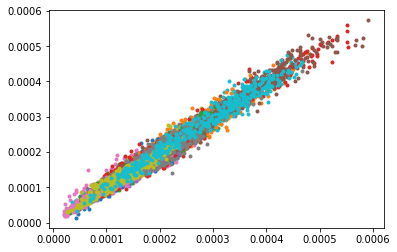

In [31]:
# lin_cor_fc2 = []

for c in range(20):
    x = software[:,c]
    y = output_corr[:,c]
    
#     plt.figure(c)
    plt.plot(x,y,'.')

#     lin_cor_fc2.append( np.polyfit(y, x, 1))

(array([  1.,   1.,   0.,   0.,   2.,   2.,   4.,   2.,   8.,   8.,  15.,
         21.,  25.,  41.,  74.,  97., 145., 191., 248., 337., 380., 493.,
        532., 597., 626., 647., 649., 599., 539., 474., 341., 241., 206.,
        110., 122.,  83.,  56.,  24.,  19.,  13.,  11.,   4.,   2.,   4.,
          3.,   0.,   2.,   0.,   0.,   1.]),
 array([-0.13890322, -0.13337673, -0.12785024, -0.12232374, -0.11679725,
        -0.11127075, -0.10574426, -0.10021776, -0.09469127, -0.08916477,
        -0.08363828, -0.07811179, -0.07258529, -0.0670588 , -0.0615323 ,
        -0.05600581, -0.05047931, -0.04495282, -0.03942633, -0.03389983,
        -0.02837334, -0.02284684, -0.01732035, -0.01179385, -0.00626736,
        -0.00074087,  0.00478563,  0.01031212,  0.01583862,  0.02136511,
         0.02689161,  0.0324181 ,  0.03794459,  0.04347109,  0.04899758,
         0.05452408,  0.06005057,  0.06557707,  0.07110356,  0.07663005,
         0.08215655,  0.08768304,  0.09320954,  0.09873603,  0.10426253,
 

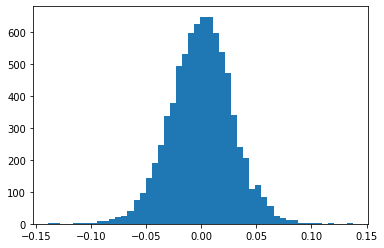

In [32]:
plt.hist((output_corr-software).reshape(-1, 1)/0.0006, bins=50 )

In [34]:
(output_corr-software).reshape(-1, 1).std()/0.0006

0.028242871241980414

In [16]:
# load_workspace(vars(), '20190821-051552-mnist_xs')
# xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, linear_factors_conv, c, x, i, result, x1, y, xs, acc, 


In [35]:
ys = []
batch_size = 100

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[idx1:idx2]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply_w_delay(0, x1, c_sel=[0, 20], debug=True)
    output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply_w_delay(0, x2, c_sel=[20, 40], debug=True)
    output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    display.clear_output(wait=True)
    
    print(f'Accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    
ys = np.concatenate(ys)  

Accuracy = 92.00%


In [36]:
np.mean(ys.argmax(axis=1) == test_labels)

0.9196

In [37]:
save_workspace(vars(), note='prober2-modFC-delay')

Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), xs(<class 'numpy.ndarray'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), finalGfc(<class 'numpy.ndarray'>), x2(<class 'numpy.ndarray'>), sc1(<class 'numpy.float64'>), sc2(<class 'numpy.float64'>), Gfc1(<class 'numpy.ndarray'>), Gfc2(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), 

In [29]:
ynew.argmax(axis=1) == test_labels

array([ True,  True, False, ...,  True,  True,  True])

In [19]:
import scipy.io as sio
#load_workspace(vars(), '20190814-205207-CNN weights')
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

(26, 14)

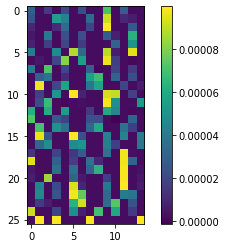

In [19]:
plt.imshow(finalGconv)
plt.colorbar()
np.shape(finalGconv)

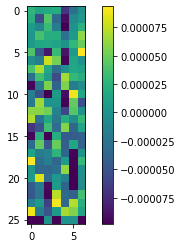

In [22]:
g1 = finalGconv[:,::2] - finalGconv[:,1::2]
plt.imshow(g1)
plt.colorbar()

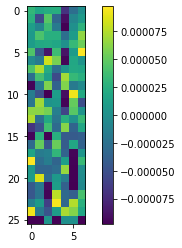

In [24]:
g2 = nn.Gconv[:,::2] - nn.Gconv[:,1::2]
plt.imshow(g2/2)
plt.colorbar()

(array([-5.0e-07,  0.0e+00,  5.0e-07,  1.0e-06,  1.5e-06,  2.0e-06,
         2.5e-06,  3.0e-06,  3.5e-06,  4.0e-06,  4.5e-06]),
 <a list of 11 Text xticklabel objects>)

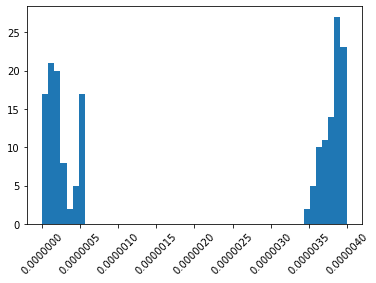

In [31]:
plt.hist((g2/2-g1).reshape(-1,1), bins=50)
plt.xticks(rotation=45)

In [4]:
import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *
vOffset = -0.08
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)